In [18]:
# Load packages
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
import os
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

### Plot al in one T = 3, 5, 10

In [118]:
k0 = 1.0
spatial_flag = 0
if spatial_flag == 0:
    cut = 75
else:
    cut = 25

colors = ['royalblue', 'orangered', 'seagreen']
colors = ['royalblue', 'orangered', 'seagreen']
fit_colors = ['navy', 'darkred', 'darkgreen'] 

In [119]:
# Load datasets for T = 3, 5, 10
target_volume = 3000
T_values = [3, 5, 10]

SAVEDIR = f'plots/diffusion/k0={k0}'
if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)
DIRNAME = f'diffusion/k0={k0}'

filenames_T3 = glob.glob(f'{DIRNAME}/*sptl={spatial_flag}_T3_N{target_volume}_k0={k0}*')
files_T3 = [measurement for filename in filenames_T3 for measurement in np.load(filename)]
filenames_T5 = glob.glob(f'{DIRNAME}/*sptl={spatial_flag}_T5_N{target_volume}_k0={k0}*')
files_T5 = [measurement for filename in filenames_T5 for measurement in np.load(filename)]
filenames_T10 = glob.glob(f'{DIRNAME}/*sptl={spatial_flag}_T10_N{target_volume}_k0={k0}*')
files_T10 = [measurement for filename in filenames_T10 for measurement in np.load(filename)]

# Load data
df_T3 = pd.DataFrame(files_T3).T
df_T5 = pd.DataFrame(files_T5).T
df_T10 = pd.DataFrame(files_T10).T

for df in [df_T3, df_T5, df_T10]:
    df.columns = [f'walker_{i}' for i in range(df.shape[1])]
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    df.index.name = 'sigma'
    df.columns.name = 'walker'


<>:35: SyntaxWarning: invalid escape sequence '\w'
<>:37: SyntaxWarning: invalid escape sequence '\w'
<>:35: SyntaxWarning: invalid escape sequence '\w'
<>:37: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_12325/4133441896.py:35: SyntaxWarning: invalid escape sequence '\w'
  ax.set_title(f'Return probability of random walkers on a spatial slice \n ($\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
/tmp/ipykernel_12325/4133441896.py:37: SyntaxWarning: invalid escape sequence '\w'
  ax.set_title(f'Return probability of random walkers \n ($\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
/tmp/ipykernel_12325/4133441896.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


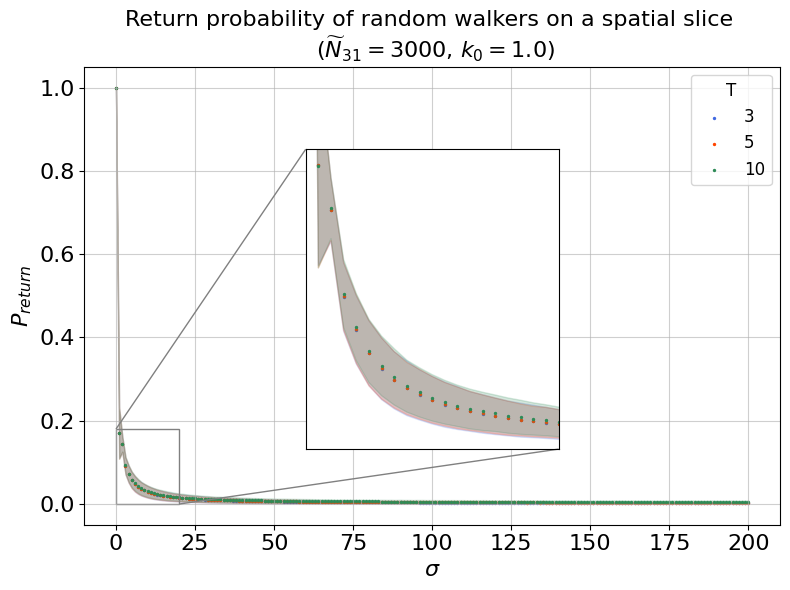

In [120]:
# Plot data regular
fig, ax = plt.subplots(figsize=(8, 6))
for i, df in enumerate([df_T3, df_T5, df_T10]):
    y = df['mean']
    y_std = df['std']
    x = np.arange(len(y))
    ax.scatter(x, y, s=2, color=colors[i], label=f'{T_values[i]}')
    ax.fill_between(x, y - y_std, y + y_std, alpha=0.2, color=colors[i])
    
axins = zoomed_inset_axes(ax, zoom=4, loc='lower center', bbox_to_anchor=(0.5, 0.15), bbox_transform=ax.transAxes)
for i, df in enumerate([df_T3, df_T5, df_T10]):
    y = df['mean']
    y_std = df['std']
    x = np.arange(len(y))
    axins.scatter(x, y, s=2, color=colors[i])
    axins.fill_between(x, y - y_std, y + y_std, alpha=0.2, color=colors[i])

if spatial_flag == 0:
    # ax.set_xlim(-5, cut)
    axins.set_xlim(0, 20)
    axins.set_ylim(0, 0.18)
else:
    # ax.set_xlim(-1, cut)
    axins.set_xlim(0, 20)
    axins.set_ylim(-0.01, 0.12)
axins.set_xticks([])
axins.set_yticks([])
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
ax.legend(title='T', loc='upper right', fancybox=True, fontsize=12, title_fontsize=12)
ax.grid(True, which="both", ls="-", alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'$\sigma$', fontsize=16)
ax.set_ylabel(r'$P_{return}$', fontsize=16)
if spatial_flag == 0:
    ax.set_title(f'Return probability of random walkers on a spatial slice \n ($\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
else:
    ax.set_title(f'Return probability of random walkers \n ($\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
plt.tight_layout()
plt.savefig(f'{SAVEDIR}/combined_return_probability_N{target_volume}_k0={k0}_sptl={spatial_flag}.png', dpi=400)


<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:46: SyntaxWarning: invalid escape sequence '\w'
<>:48: SyntaxWarning: invalid escape sequence '\w'
<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:46: SyntaxWarning: invalid escape sequence '\w'
<>:48: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_12325/1637733030.py:36: SyntaxWarning: invalid escape sequence '\p'
  legend_label = f'$a = {slope:.2e} \pm {std_err:.2e}$ \n $R^2={r_value:.2e}$, $p$-$value={p_value:.2e}$'
/tmp/ipykernel_12325/1637733030.py:46: SyntaxWarning: invalid escape sequence '\w'
  plt.title(f'Fitted return probability of random walkers on a spatial slice \n ($\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
/tmp/ipykernel_12325/1637733030.py:48: SyntaxWarning: invalid escape sequence '\w'
  plt.title(f'Return probability of random walkers \n ($\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)


Results of log-log fit (N31=3000, k0=1.0):
--------------------------------------------------------------------------------
T = 3
Slope: -0.9266837405366208 +- 0.006113366417314368
Intercept: -1.4273554616685913
R-squared: -0.9984369204404598
P-value: 6.03395262842722e-92
Spectral dimension: 1.8533674810732417 +- 0.012226732834628736

T = 5
Slope: -0.8981191304968077 +- 0.006495595184518543
Intercept: -1.4817370607175695
R-squared: -0.9981222062306699
P-value: 4.42871690176964e-89
Spectral dimension: 1.7962382609936154 +- 0.012991190369037085

T = 10
Slope: -0.8260392448865113 +- 0.00779832925089584
Intercept: -1.586861710544078
R-squared: -0.9968068432770801
P-value: 8.652541821290571e-81
Spectral dimension: 1.6520784897730225 +- 0.01559665850179168

--------------------------------------------------------------------------------


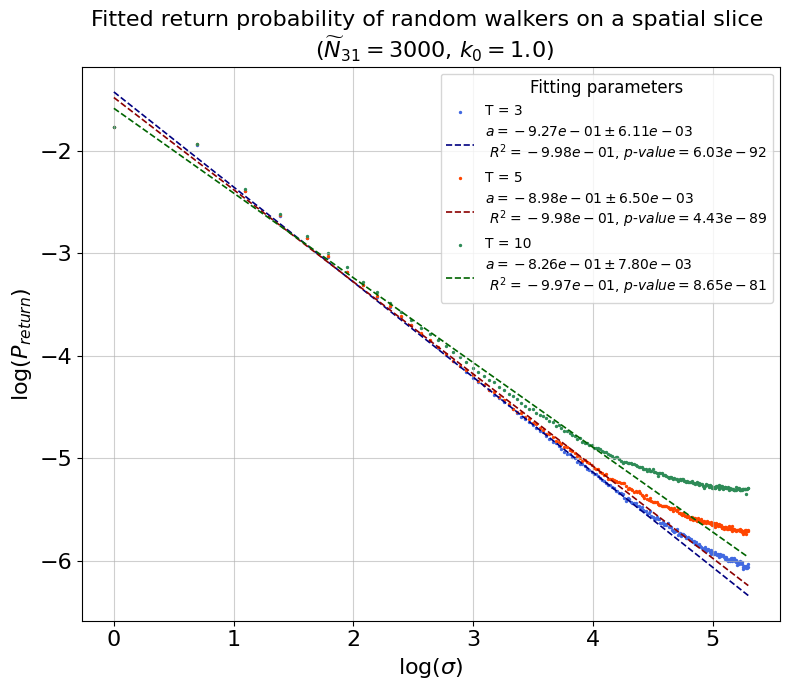

In [121]:
# Fit log-log
slopes = []
intercepts = []
r_values = []
p_values = []
std_errs = []
D_values = []
D_std = []

plt.figure(figsize=(8, 7))
for i, df in enumerate([df_T3, df_T5, df_T10]):
    Y = df['mean'][1:]
    Y_std = df['std'][1:]
    X = np.arange(1, len(Y) + 1)
    logX = np.log(X)
    logY = np.log(Y)
    logY_std = Y_std / Y
    y = df['mean'][1:cut]
    y_std = df['std'][1:cut]
    x = np.arange(1, len(y) + 1)
    logx = np.log(x)
    logy = np.log(y)
    logy_std = y_std / y

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
    slopes.append(slope)
    intercepts.append(intercept)
    r_values.append(r_value)
    p_values.append(p_value)
    std_errs.append(std_err)
    D_values.append(-2 * slope)
    D_std.append(2 * std_err)

    # Plot
    legend_label = f'$a = {slope:.2e} \pm {std_err:.2e}$ \n $R^2={r_value:.2e}$, $p$-$value={p_value:.2e}$'
    plt.scatter(logX, logY, color=colors[i], label=f'T = {T_values[i]}', s=2)
    plt.plot(logX, slope * logX + intercept, color=fit_colors[i], linestyle='dashed', linewidth=1.2, label=legend_label)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid(True, which="both", ls="-", alpha=0.6)
plt.xlabel(r'$\log(\sigma)$', fontsize=16)
plt.ylabel(r'$\log(P_{return})$', fontsize=16)
if spatial_flag == 0:
    plt.title(f'Fitted return probability of random walkers on a spatial slice \n ($\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
else:
    plt.title(f'Return probability of random walkers \n ($\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
plt.tight_layout()
plt.legend(title='Fitting parameters', fancybox=True, fontsize=10, title_fontsize=12)
plt.savefig(f'{SAVEDIR}/combined_loglog_N{target_volume}_k0={k0}_sptl={spatial_flag}.png', dpi=400)

# Print results of fit with all info
print(f'Results of log-log fit (N31={target_volume}, k0={k0}):')
print('-'*80)
for i, T in enumerate(T_values):
    print(f'T = {T}')
    print(f'Slope: {slopes[i]} +- {std_errs[i]}')
    print(f'Intercept: {intercepts[i]}')
    print(f'R-squared: {r_values[i]}')
    print(f'P-value: {p_values[i]}')
    print(f'Spectral dimension: {D_values[i]} +- {D_std[i]}')
    print()
print('-'*80)

# Save results
with open(f'{SAVEDIR}/combined_results_loglog_N3000_k0={k0}_sptl={spatial_flag}.txt', 'w') as f:
    f.write(f'Results of log-log fit (N31={target_volume}, k0={k0}):\n')
    f.write('-'*80 + '\n')
    for i, T in enumerate(T_values):
        f.write(f'T = {T}\n')
        f.write(f'Slope: {slopes[i]} +- {std_errs[i]}\n')
        f.write(f'Intercept: {intercepts[i]}\n')
        f.write(f'R-squared: {r_values[i]}\n')
        f.write(f'P-value: {p_values[i]}\n')
        f.write(f'Spectral dimension: {D_values[i]} +- {D_std[i]}\n\n')
    f.write('-'*80 + '\n')


### Plot all-in one Ñ31 = 3000, 6000, 9000

In [122]:
# Load datasets for T = 3, 5, 10
T = 3
N31_values = [3000, 6000, 9000]

SAVEDIR = f'plots/diffusion/k0={k0}'
if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)
DIRNAME = f'diffusion/k0={k0}'

filenames_3000 = glob.glob(f'{DIRNAME}/*sptl={spatial_flag}_T{T}_N3000_k0={k0}*')
files_3000 = [measurement for filename in filenames_3000 for measurement in np.load(filename)]
filenames_6000 = glob.glob(f'{DIRNAME}/*sptl={spatial_flag}_T{T}_N6000_k0={k0}*')
files_6000 = [measurement for filename in filenames_6000 for measurement in np.load(filename)]
filenames_9000 = glob.glob(f'{DIRNAME}/*sptl={spatial_flag}_T{T}_N9000_k0={k0}*')
files_9000 = [measurement for filename in filenames_9000 for measurement in np.load(filename)]

# Load data
df_3000 = pd.DataFrame(files_3000).T
df_6000 = pd.DataFrame(files_6000).T
df_9000 = pd.DataFrame(files_9000).T

for df in [df_3000, df_6000, df_9000]:
    df.columns = [f'walker_{i}' for i in range(df.shape[1])]
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    df.index.name = 'sigma'
    df.columns.name = 'walker'

<>:29: SyntaxWarning: invalid escape sequence '\w'
<>:29: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_12325/525422432.py:29: SyntaxWarning: invalid escape sequence '\w'
  ax.legend(title='$\widetilde{N}_{31}$', loc='upper right', fancybox=True, fontsize=12, title_fontsize=12)
/tmp/ipykernel_12325/525422432.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


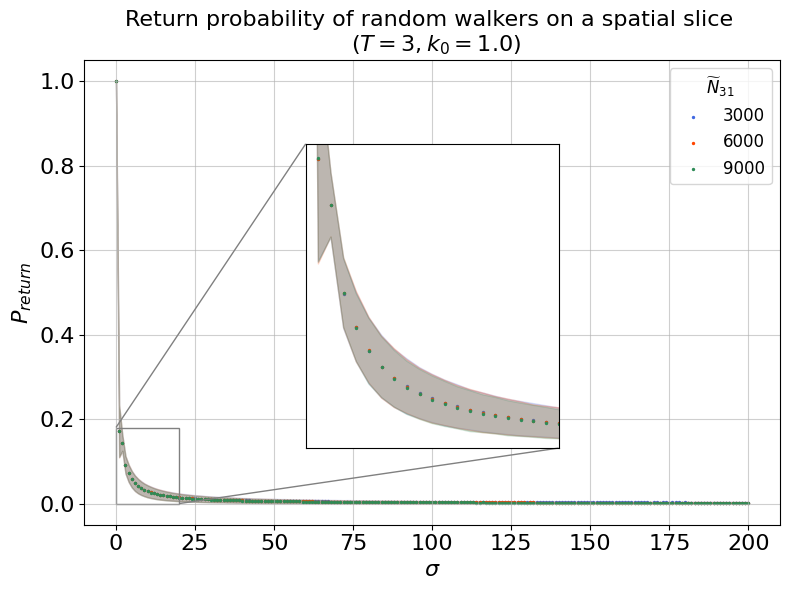

In [123]:
# Plot data regular
fig, ax = plt.subplots(figsize=(8, 6))
for i, df in enumerate([df_3000, df_6000, df_9000]):
    y = df['mean']
    y_std = df['std']
    x = np.arange(len(y))
    ax.scatter(x, y, s=2, color=colors[i], label=f'{N31_values[i]}')
    ax.fill_between(x, y - y_std, y + y_std, alpha=0.2, color=colors[i])

axins = zoomed_inset_axes(ax, zoom=4, loc='lower center', bbox_to_anchor=(0.5, 0.15), bbox_transform=ax.transAxes)
for i, df in enumerate([df_3000, df_6000, df_9000]):
    y = df['mean']
    y_std = df['std']
    x = np.arange(len(y))
    axins.scatter(x, y, s=2, color=colors[i])
    axins.fill_between(x, y - y_std, y + y_std, alpha=0.2, color=colors[i])

if spatial_flag == 0:
    # ax.set_xlim(-5, cut)
    axins.set_xlim(0, 20)
    axins.set_ylim(0, 0.18)
else:
    # ax.set_xlim(-1, cut)
    axins.set_xlim(0, 20)
    axins.set_ylim(-0.01, 0.12)
axins.set_xticks([])
axins.set_yticks([])
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
ax.legend(title='$\widetilde{N}_{31}$', loc='upper right', fancybox=True, fontsize=12, title_fontsize=12)
ax.grid(True, which="both", ls="-", alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'$\sigma$', fontsize=16)
ax.set_ylabel(r'$P_{return}$', fontsize=16)
if spatial_flag == 0:
    ax.set_title(f'Return probability of random walkers on a spatial slice \n ($T={T}, k_0={k0}$)', fontsize=16)
else:
    ax.set_title(f'Return probability of random walkers \n ($T={T}, k_0={k0}$)', fontsize=16)
plt.tight_layout()
plt.savefig(f'{SAVEDIR}/combined_return_probability_T{T}_k0={k0}_sptl={spatial_flag}.png', dpi=400)

<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\w'
<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_12325/4036684407.py:37: SyntaxWarning: invalid escape sequence '\p'
  legend_label = f'$a = {slope:.2e} \pm {std_err:.2e}$ \n $R^2={r_value:.2e}$, $p$-$value={p_value:.2e}$'
/tmp/ipykernel_12325/4036684407.py:38: SyntaxWarning: invalid escape sequence '\w'
  plt.scatter(logX, logY, color=colors[i], label=f'$\widetilde{{N}}_{{31}}$ = {N31_values[i]}', s=2)


Results of log-log fit (T=3, k0=1.0):
--------------------------------------------------------------------------------
N31 = 3000
Slope: -0.9266837405366208 +- 0.006113366417314368
Intercept: -1.4273554616685913
R-squared: -0.9984369204404598
P-value: 6.03395262842722e-92
Spectral dimension: 1.8533674810732417 +- 0.012226732834628736

N31 = 6000
Slope: -0.9517227216660056 +- 0.006649375294330283
Intercept: -1.3826142192192474
R-squared: -0.9982473290672743
P-value: 3.70760640817141e-90
Spectral dimension: 1.9034454433320112 +- 0.013298750588660566

N31 = 9000
Slope: -0.9771803527934552 +- 0.007182986900149685
Intercept: -1.3449338994219335
R-squared: -0.9980604621054092
P-value: 1.417863567481552e-88
Spectral dimension: 1.9543607055869103 +- 0.01436597380029937

--------------------------------------------------------------------------------


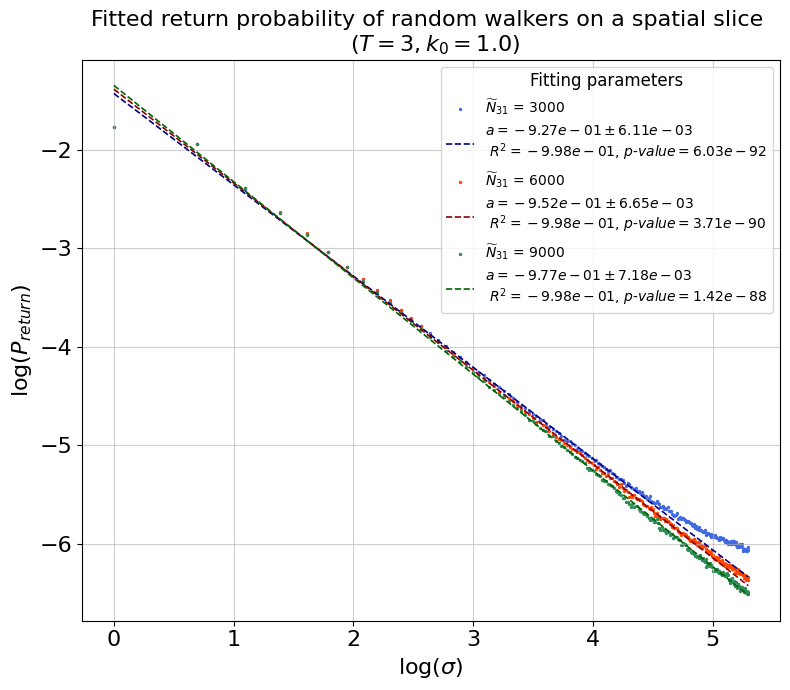

In [124]:
# Fit log-log
slopes = []
intercepts = []
r_values = []
p_values = []
std_errs = []
D_values = []
D_std = []


plt.figure(figsize=(8, 7))
for i, df in enumerate([df_3000, df_6000, df_9000]):
    Y = df['mean'][1:]
    Y_std = df['std'][1:]
    X = np.arange(1, len(Y) + 1)
    logX = np.log(X)
    logY = np.log(Y)
    logY_std = Y_std / Y
    y = df['mean'][1:cut]
    y_std = df['std'][1:cut]
    x = np.arange(1, len(y) + 1)
    logx = np.log(x)
    logy = np.log(y)
    logy_std = y_std / y

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(logx, logy)
    slopes.append(slope)
    intercepts.append(intercept)
    r_values.append(r_value)
    p_values.append(p_value)
    std_errs.append(std_err)
    D_values.append(-2 * slope)
    D_std.append(2 * std_err)

    # Plot
    legend_label = f'$a = {slope:.2e} \pm {std_err:.2e}$ \n $R^2={r_value:.2e}$, $p$-$value={p_value:.2e}$'
    plt.scatter(logX, logY, color=colors[i], label=f'$\widetilde{{N}}_{{31}}$ = {N31_values[i]}', s=2)
    plt.plot(logX, slope * logX + intercept, color=fit_colors[i], linestyle='dashed', linewidth=1.2, label=legend_label)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid(True, which="both", ls="-", alpha=0.6)
plt.xlabel(r'$\log(\sigma)$', fontsize=16)
plt.ylabel(r'$\log(P_{return})$', fontsize=16)
if spatial_flag == 0:
    plt.title(f'Fitted return probability of random walkers on a spatial slice \n ($T={T}, k_0={k0}$)', fontsize=16)
else:
    plt.title(f'Fitted return probability of random walkers \n ($T={T}, k_0={k0}$)', fontsize=16)
plt.tight_layout()
plt.legend(title='Fitting parameters', fancybox=True, fontsize=10, title_fontsize=12)
plt.savefig(f'{SAVEDIR}/combined_loglog_T{T}_k0={k0}_sptl={spatial_flag}.png', dpi=400)

# Print results of fit with all info
print(f'Results of log-log fit (T={T}, k0={k0}):')
print('-'*80)
for i, N31 in enumerate(N31_values):
    print(f'N31 = {N31}')
    print(f'Slope: {slopes[i]} +- {std_errs[i]}')
    print(f'Intercept: {intercepts[i]}')
    print(f'R-squared: {r_values[i]}')
    print(f'P-value: {p_values[i]}')
    print(f'Spectral dimension: {D_values[i]} +- {D_std[i]}')
    print()
print('-'*80)

# Save results
with open(f'{SAVEDIR}/combined_results_loglog_T3_k0={k0}_sptl={spatial_flag}.txt', 'w') as f:
    f.write(f'Results of log-log fit (T={T}, k0={k0}):\n')
    f.write('-'*80 + '\n')
    for i, N31 in enumerate(N31_values):
        f.write(f'N31 = {N31}\n')
        f.write(f'Slope: {slopes[i]} +- {std_errs[i]}\n')
        f.write(f'Intercept: {intercepts[i]}\n')
        f.write(f'R-squared: {r_values[i]}\n')
        f.write(f'P-value: {p_values[i]}\n')
        f.write(f'Spectral dimension: {D_values[i]} +- {D_std[i]}\n\n')
    f.write('-'*80 + '\n')


### Load data

In [125]:
# k0 = 1.0
# target_volume = 9000
# T = 3
# spatial_flag = 0

# SAVEDIR = f'plots/diffusion/k0={k0}'
# if not os.path.exists(SAVEDIR):
#     os.makedirs(SAVEDIR)
# DIRNAME = f'diffusion/k0={k0}'
# filenames = glob.glob(f'{DIRNAME}/*sptl={spatial_flag}_T{T}_N{target_volume}_k0={k0}*')

# files = [measurement for filename in filenames for measurement in np.load(filename)]
# print(f'Loaded {len(files)} files')

# df = pd.DataFrame(files).T
# df['mean'] = df.mean(axis=1)
# df['std'] = df.std(axis=1)
# df.index.name = 'sigma'
# df.columns.name = 'walker'
# df

### Simple plot of the return probability

In [126]:
# y = df['mean']
# y_std = df['std']
# x = np.arange(len(y))

# # Plot the average return probability
# plt.figure(figsize=(8,6))
# plt.plot(x, y, linewidth=1, linestyle='dashed')
# plt.fill_between(x, y - y_std, y + y_std, alpha=0.3)
# plt.yticks(fontsize=16)
# plt.xticks(fontsize=16)
# plt.grid(True, which="both", ls="-", alpha=0.6)
# plt.xlabel(r'$\sigma$', fontsize=16)
# plt.ylabel(r'$P_{return}$', fontsize=16)
# if spatial_flag == 0:
#     plt.title(f'Return probability of random walkers on a spatial slice \n ($T=${T}, $\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
# else:
#     plt.title('Return probability of random walkers \n ($T=${T}, $\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
# plt.tight_layout()
# plt.savefig(f'{SAVEDIR}/return_probability_T{T}_N{target_volume}_k0={k0}_sptl={spatial_flag}.png', dpi=400)

### Power-law fit

In [127]:
# def power_law(x, a, b):
#     return a * x ** b

# Y = df['mean'][1:]
# X = np.arange(1, len(Y) + 1)

# popt, pcov = curve_fit(power_law, X, Y, p0=[1, -1])
# a, b = popt
# a_std, b_std = np.sqrt(np.diag(pcov))

# print('-'*50)
# print(f'Fitted power law: P_return = {a:.2f} * sigma^{b:.2f}')
# print(f'Error in a: {a_std:.2E}, error in b: {b_std:.2E}')
# print(f'Spectral dimension: d_s = {-2 * b:.2f} ± {2 * b_std:.2f}')
# print('-'*50)

# # Write the results to a file
# with open(f'{SAVEDIR}/powerlaw_T{T}_N{target_volume}_k0{k0}_sptl{spatial_flag}.txt', 'w') as f:
#     f.write(f'Fitted power law: P_return = {a:.2f} * sigma^{b:.2f}\n')
#     f.write(f'Error in a: {a_std:.2E}, error in b: {b_std:.2E}\n')
#     f.write(f'Spectral dimension: d_s = {-2 * b:.2f} ± {2 * b_std:.2f}\n')

# plt.figure(figsize=(8,6))
# plt.scatter(X, Y, s=2, label='Data', zorder=3, color='b')
# plt.plot(X, power_law(X, *popt), color='red', linewidth=2, label='Fit', linestyle='dashed', zorder=2)
# plt.ylim(0, 0.18)
# plt.yticks(fontsize=16)
# plt.xticks(fontsize=16)
# plt.grid(True, which="both", ls="-", alpha=0.6)
# plt.xlabel(r'$\sigma$', fontsize=16)
# plt.ylabel(r'$P_{return}$', fontsize=16)
# if spatial_flag == 0:
#     plt.title(f'Return probability of random walkers on a spatial slice \n ($T=${T}, $\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
# else:
#     plt.title('Return probability of random walkers \n ($T=${T}, $\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
# plt.legend(fontsize=16)
# plt.tight_layout()
# plt.savefig(f'{SAVEDIR}/powerlaw_T{T}_N{target_volume}_k0{k0}_sptl{spatial_flag}.png', dpi=400)

### Log-log fit

In [128]:
# # Fit a linear function to the log-log data
# logX = np.log(X)
# logY = np.log(Y)
# slope, intercept, r_value, p_value, std_err = linregress(logX, logY)

# print('-'*70)
# print(f'Fitted linear function: log(P_return) = {slope:.2f} * log(sigma) + {intercept:.2f}')
# print(f'p-value: {p_value:.2E}, R^2: {r_value:.2E}, standard error: {std_err:.2E}')
# print(f'Spectral dimension: d_s = {-2 * slope:.2f} ± {2 * std_err:.2f}')
# print('-'*70)

# # Write the results to a file
# with open(f'{SAVEDIR}/results_loglog_T{T}_N{target_volume}_k0={k0}_sptl={spatial_flag}.txt', 'a') as f:
#     f.write('-'*70 + '\n')
#     f.write(f'Fitted linear function: log(P_return) = {slope:.2f} * log(sigma) + {intercept:.2f}\n')
#     f.write(f'p-value: {p_value:.2E}, R^2: {r_value:.2E}, standard error: {std_err:.2E}\n')
#     f.write(f'Spectral dimension: d_s = {-2 * slope:.2f} ± {2 * std_err:.2f}\n')
#     f.write('-'*70 + '\n')

# plt.figure(figsize=(8,6))
# plt.scatter(logX, logY, s=2, label='Data', zorder=3, color='b')
# plt.plot(logX, slope*logX + intercept, color='red', linewidth=2, label='Fit', linestyle='dashed', zorder=2)
# plt.yticks(fontsize=16)
# plt.xticks(fontsize=16)
# plt.grid(True, which="both", ls="-", alpha=0.6)
# plt.xlabel(r'$\log(\sigma)$', fontsize=16)
# plt.ylabel(r'$\log(P_{return})$', fontsize=16)
# if spatial_flag == 0:
#     plt.title(f'Return probability of random walkers on a spatial slice \n ($T=${T}, $\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
# else:
#     plt.title('Return probability of random walkers \n ($T=${T}, $\widetilde{{N}}_{{31}}=${target_volume}, $k_0=${k0})', fontsize=16)
# plt.legend(fontsize=16)
# plt.tight_layout()
# plt.savefig(f'{SAVEDIR}/loglog_T{T}_N{target_volume}_k0={k0}_sptl={spatial_flag}.png', dpi=400)
